In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

C:\Users\jains\anaconda3\envs\DL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 64
learning_rate = 1e-3
epochs = 5

In [4]:
train_dataset = torchvision.datasets.LFWPairs(root='./data/LFW',
                                             split='train',
                                             download=True,
                                             transform=ToTensor())

test_dataset = torchvision.datasets.LFWPairs(root='./data/LFW',
                                            split='test',
                                            download=True,
                                            transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size)

In [6]:
data_iter = iter(train_loader)
img1, img2, label = next(data_iter)
print(f'First image shape: {img1.shape}, Second image shape: {img2.shape}, Labels Shape: {label.shape}')

First image shape: torch.Size([64, 3, 250, 250]), Second image shape: torch.Size([64, 3, 250, 250]), Labels Shape: torch.Size([64])


In [7]:
def imshow(img1, img2):
    npimg1, npimg2 = np.transpose(img1.numpy(), (1, 2, 0)), np.transpose(img2.numpy(), (1, 2, 0))
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(npimg1)
    fig.add_subplot(1, 2, 2)
    plt.imshow(npimg2)
    plt.show()

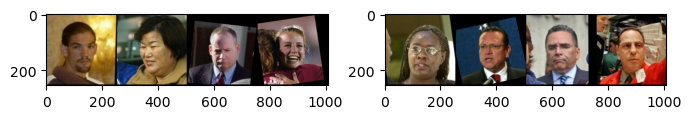

Labels: tensor([0, 0, 0, 0])


In [8]:
imshow(torchvision.utils.make_grid(img1[:4]), torchvision.utils.make_grid(img2[:4]))
print(f'Labels: {label[:4]}')

In [9]:
vgg = torchvision.models.vgg11_bn(weights='DEFAULT')

In [10]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [11]:
vgg = vgg.features

In [12]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.embedding = nn.Sequential(
            vgg.requires_grad_(False),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(512*7*7, 1024),
        )
        self.linear = nn.Sequential(nn.Linear(1024, 128), nn.Sigmoid())
        self.out = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward_one(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
    def forward(self, img1, img2):
        embedding1 = self.forward_one(img1)
        embedding2 = self.forward_one(img2)
        distance = torch.abs(embedding1 - embedding2)
        out = self.out(distance).squeeze()
        out = self.sigmoid(out)
        return out

In [14]:
model = CNN().to(device)

In [15]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [16]:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [17]:
total_step = len(train_loader)
curr_lr = learning_rate
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (img1, img2, labels) in enumerate(train_loader):
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.float()
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % 5 == 0:
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, running_loss/5))
            losses.append(running_loss/5)
            running_loss = 0.0
    
    if (epoch + 1) % 2 == 0:
        curr_lr /= 2
        update_lr(optimizer, curr_lr)

Epoch: [1/5], Step: [5/35], Loss: 0.6771
Epoch: [1/5], Step: [10/35], Loss: 0.6525
Epoch: [1/5], Step: [15/35], Loss: 0.6069
Epoch: [1/5], Step: [20/35], Loss: 0.5891
Epoch: [1/5], Step: [25/35], Loss: 0.5914
Epoch: [1/5], Step: [30/35], Loss: 0.5471
Epoch: [1/5], Step: [35/35], Loss: 0.5601
Epoch: [2/5], Step: [5/35], Loss: 0.4114
Epoch: [2/5], Step: [10/35], Loss: 0.3867
Epoch: [2/5], Step: [15/35], Loss: 0.3640
Epoch: [2/5], Step: [20/35], Loss: 0.3582
Epoch: [2/5], Step: [25/35], Loss: 0.3416
Epoch: [2/5], Step: [30/35], Loss: 0.3361
Epoch: [2/5], Step: [35/35], Loss: 0.3370
Epoch: [3/5], Step: [5/35], Loss: 0.2062
Epoch: [3/5], Step: [10/35], Loss: 0.1979
Epoch: [3/5], Step: [15/35], Loss: 0.1869
Epoch: [3/5], Step: [20/35], Loss: 0.1932
Epoch: [3/5], Step: [25/35], Loss: 0.1795
Epoch: [3/5], Step: [30/35], Loss: 0.1707
Epoch: [3/5], Step: [35/35], Loss: 0.1618
Epoch: [4/5], Step: [5/35], Loss: 0.0965
Epoch: [4/5], Step: [10/35], Loss: 0.1024
Epoch: [4/5], Step: [15/35], Loss: 0.1

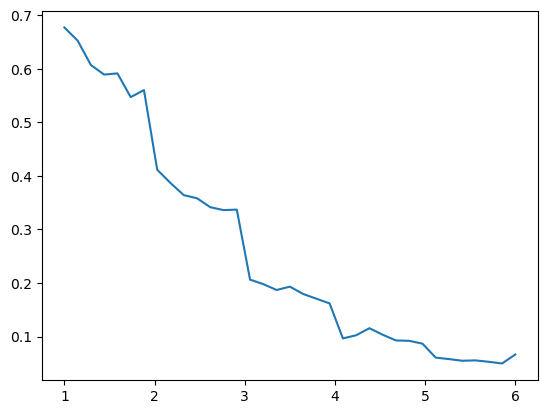

In [18]:
plt.plot(np.linspace(1, epochs+1, num=len(losses)), losses)

In [19]:
total = 0
correct = 0
model.eval()
with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.float()
        labels = labels.to(device)
        
        outputs = model(img1, img2)
        predicted = [1. if i > 0.5 else 0. for i in outputs]
        predicted = torch.tensor(predicted).to(device)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on test images: {(100 * correct) / total}')

Accuracy of the network on test images: 71.7
